# Классификация текстов с активным обучением


Зададимся простой задачей классификации текстов: например, классификацией отзывов на банки по тональности. Эта задача решается с достаточно высокими показателями качества с использованием стандартных алгоритмов классификации, например, сверточных нейронных сетей: корпус состоит из достаточного количества документов, чтобы сверточная сеть хорошо обучилась. Однако возникает естественный вопрос: действительно ли все документы нужны для того, чтобы достичь таких высоких показателей качества (или сопоставимых с ними). Парадигма активного обучения поможет вам ответить на этот вопрос.

## Часть 1. Предобработка данных [2 балла]

Коллекция отзывов хранится в файле banki_responses (https://www.dropbox.com/s/ol3ux3ibr6rd5ke/banki_responses.json.bz2?dl=0). Одна строчка в этом файле соответствует одному json-словарю. Из этого словаря вам понадобятся два значения по ключам text и rating -- текст отзыва и его оценка по шкале от 1 до 5.   

Считайте файл. Посчитайте, каких отзывов больше: положительных или отрицательных? 

Проведите предварительную обработку данных: удалите слишком короткие и слишком длинные тексты (пороги на длину определите самостоятельно). 

Разбейте данные на обучающее ($train$) и тестовое ($test$) множество случайным образом в отношеннии 3:1 (или любом другом отношении, которое покажется вам разумным). 

Задача классификации сформулирована так: по каждому отзыву определить его оценку (т.е. классификация на 5 классов). Признаками для классификации выступают слова.

136189


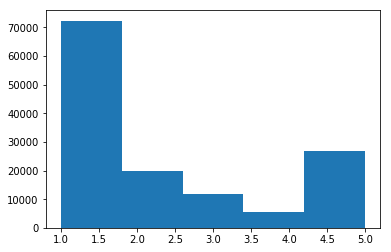

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

texts = []
grades = []
with open('./banki_responses.json', 'r') as f:
    for line in f:
        parsed = json.loads(line.strip())
        if parsed['rating_grade'] is not None: # delete responses without grade
            texts.append(parsed['text'])
            grades.append(parsed['rating_grade'])
texts = np.array(texts)
grades = np.array(grades)
print(len(texts))
plt.hist(grades, 5)
plt.show()

In [2]:
print(len(grades[grades < 3]), len(grades[grades > 3]))

92235 32252


> Видно, что негативные отзывы преобладают почти в три раза

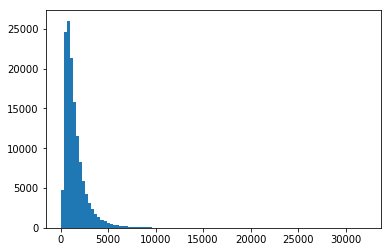

In [3]:
plt.hist(list(map(len, texts)), bins=100)
plt.show()

> отсечем тексты, длины которых находятся после 90-перцентили и до 10-перцентили, тем самым оставив 80% выборки

In [4]:
from scipy.stats.mstats import mquantiles
texts_lens = np.array(list(map(len, texts)))
low, high = mquantiles(texts_lens, [0.1, 0.9])
print(low, high)

472.0 2913.0


In [5]:
mask = (texts_lens >= low) & (texts_lens <= high)
texts = texts[mask]
grades = grades[mask]
len(texts)

109017

## Часть 2. Baseline [4 балла]

Получите baseline классификации: в идеале, используйте сверточную нейронную сеть (слой эмбеддингов + свертка + субдескритизация). Число и размерность фильтров определите самостоятельно, так же как и использование регуляризаторов (dropout / batch norm) и их параметров. Так же самостоятельно (но обосновано) решите, использовать ли вам предобученные эмбеддинги или нет и проводить ли вам лемматизацию или нет. 

Обучите сеть на обучающем множестве и протестируйте на тестовом. Зафиксируйте baseline.

Если совсем трудно или вычисления занимают слишком много времени, используйте любой другой известный и симпатичный вам алгоритм классификации. 

In [6]:
# cleaning
import stop_words
ru_stop_words = stop_words.get_stop_words('russian')
import re
rewords = re.compile('[а-яА-ЯёЁ]+')
clean = lambda word : word not in ru_stop_words
lower = lambda word : word.lower()

words = np.array(list(map(lambda text: list(filter(clean, map(lower, rewords.findall(text)))), texts)))
words_len = np.array(list(map(len, words)))

mask = words_len > 0
words = words[mask]
grades = grades[mask]
MAX_WORDS = words_len.max()

In [7]:
import fastText
embeddings_model = fastText.load_model('./wiki.ru.bin')
DIM = embeddings_model.get_dimension()

def get_embeddings(words):
    return np.array(list(map(lambda word : embeddings_model.get_word_vector(word), words)))

In [8]:
embeddings = np.array(list(map(get_embeddings, words)))
embeddings.shape

(109015,)

In [10]:
import keras
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D

/Users/tkhismatullin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
NUM_CLASSES = 5
BATCH_SIZE = 64
def build_model():
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(MAX_WORDS, DIM)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model
baseline_model = build_model()
baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [12]:
from sklearn.model_selection import train_test_split
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(embeddings, grades-1, test_size=test_size, shuffle=True, stratify=grades)

In [49]:
def add_zeros_to_batch(embdeggings, targets, batch_size):
    batch_x = []
    batch_y = []
    for i, e in enumerate(embdeggings):
        batch_x.append(np.append(e, np.zeros((MAX_WORDS - e.shape[0]) * DIM).reshape(-1, DIM), axis=0))
        batch_y.append(targets[i])
        if len(batch_x) == batch_size:
            yield np.array(batch_x), np.array(batch_y)
            batch_x.clear()
            batch_y.clear()
#     if len(batch_x) > 0:
#         yield np.array(batch_x), batch_y

In [50]:
baseline_model.fit_generator(add_zeros_to_batch(X_train, y_train, BATCH_SIZE), 
                             steps_per_epoch= len(X_train) // BATCH_SIZE)

Epoch 1/1
1277/1277 [==============================] - 299s 234ms/step - loss: 0.9523 - acc: 0.6639


In [69]:
TEST_BATCH_SIZE = 1000
_, accuracy = baseline_model.evaluate_generator(add_zeros_to_batch(X_test, y_test, TEST_BATCH_SIZE), 
                                                steps= len(X_test) // TEST_BATCH_SIZE)
print(accuracy)

0.6863703705646373


---
# Baseline: 0.6863 accuracy
---

## Часть 3. Baseline [4 балла] Активное обучение

Подход активного обучения основан на следующей идее: вместо всего обучающего множества мы используем его маленькие фрагменты, в которых модель неуверена для обучения. Таким образом, модель обучается исключительно по **трудным** объектам, число которых существенно меньше, чем общее число объектов.

Обучение модели начинается с обучения по $N$ случайно выбранным примерам, где $N$ – небольшое число (100, 200 и т.д.). Затем модель тестируется на $|train| - N$ объектах, после чего из  $|train| - N$ объектов выбираются снова $N$  объектов, в которых модель не уверена. Эти объекты используются для дообучения модели. Процесс выбора $N$ трудных объектов и дообучения на них повторяется некоторое количество раз (100, 200 и т.д. раз). На каждом шаге активного обучения модель можно протестировать на тестовом множестве, чтобы сравнить ее качества с baseline.

Как выбирать трудные объекты:
1. Выход нейронной сети - оценки 5 вероятностей принадлежности объекта одному из классов. Предсказанный класс – это тот класс, вероятность которого максимальна. Отсортируем объекты по убыванию вероятности предсказанного класса ($\min \max p_i$) и выберем $N$ первых объектов;
2. Используем энтропию: чем больше энтропия предсказания, тем ближе распределение вероятностей предсказания к равномерному распределению, тем труднее объект. 

In [70]:
AL_BATCH_SIZE = 256
KERAS_BATCH_SIZE = 32
N_STEPS = 100
active_learning_model = build_model()
active_learning_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
remaining_samples = np.arange(len(X_train))
chosen = np.random.choice(remaining_samples, AL_BATCH_SIZE, replace=False)
remaining_samples = remaining_samples[~np.isin(remaining_samples, chosen)]


active_learning_model.fit_generator(add_zeros_to_batch(X_train[chosen], y_train[chosen], KERAS_BATCH_SIZE), 
                                 steps_per_epoch= AL_BATCH_SIZE // KERAS_BATCH_SIZE)

accuracies = [active_learning_model.evaluate_generator(add_zeros_to_batch(X_test, y_test, TEST_BATCH_SIZE),
                                                steps= len(X_test) // TEST_BATCH_SIZE,
                                                workers=8)[1]]
for step in range(N_STEPS):
    # predict on train
    predicted = active_learning_model.predict_generator(
        add_zeros_to_batch(X_train[remaining_samples], y_train[remaining_samples], KERAS_BATCH_SIZE), 
        steps= len(remaining_samples) // KERAS_BATCH_SIZE,
        workers=8)
    
    # get max predicted probability on each case
    predicted_max = predicted.max(axis=1)
    # get batch with the least max probability
    batch_mask = remaining_samples[predicted_max.argsort()[:AL_BATCH_SIZE]]
    # fit model
    active_learning_model.fit_generator(add_zeros_to_batch(X_train[batch_mask], y_train[batch_mask], KERAS_BATCH_SIZE), 
                                 steps_per_epoch= AL_BATCH_SIZE // KERAS_BATCH_SIZE)
    # delete trat samples from train
    remaining_samples = remaining_samples[~np.isin(remaining_samples, batch_mask)]
    
    acc = active_learning_model.evaluate_generator(add_zeros_to_batch(X_test, y_test, TEST_BATCH_SIZE), 
                                                    steps=len(X_test) // TEST_BATCH_SIZE, 
                                                   workers=8)[1]
    accuracies.append(acc)
    print('Step %d: accuracy on test %.4f' % (step + 1, acc))

Epoch 1/1
8/8 [==============================] - 1s 96ms/step - loss: 1.3179 - acc: 0.5664
Epoch 1/1
8/8 [==============================] - 1s 99ms/step - loss: 1.5021 - acc: 0.3359
Step 1: accuracy on test 0.5341
Epoch 1/1
8/8 [==============================] - 1s 102ms/step - loss: 1.4725 - acc: 0.2383
Step 2: accuracy on test 0.1883
Epoch 1/1
8/8 [==============================] - 1s 117ms/step - loss: 1.4323 - acc: 0.2227
Step 3: accuracy on test 0.1883
Epoch 1/1
8/8 [==============================] - 1s 100ms/step - loss: 1.3766 - acc: 0.4375
Step 4: accuracy on test 0.5341
Epoch 1/1
8/8 [==============================] - 1s 175ms/step - loss: 1.4676 - acc: 0.2734
Step 5: accuracy on test 0.5341
Epoch 1/1
8/8 [==============================] - 1s 104ms/step - loss: 1.4324 - acc: 0.1836
Step 6: accuracy on test 0.1883
Epoch 1/1
8/8 [==============================] - 1s 93ms/step - loss: 1.3835 - acc: 0.4766
Step 7: accuracy on test 0.1883
Epoch 1/1
8/8 [============================

# См hw3_fully_connected